In [1]:
import os
import pandas as pd
import numpy as np
from bambi import Model
import arviz as az
from scipy.stats import mode

from utils.plotting import despine, cm2inch
from utils.general import make_sure_path_exists

import matplotlib.pyplot as plt
%matplotlib inline

# Data I/O

In [2]:
setsizes = np.array([9,16,25,36])
subjects = np.arange(49)
n_subjects = subjects.size

# make sure output dir exists
make_sure_path_exists('figures/')

# set model-specifications
model_names = ['probabilistic_satisficing', 'GLAM', 'independent_accumulation']
model_titles = ['PSM', 'GLAM', 'IAM']
gaze_biases = ['with_active_gaze', 'with_passive_gaze']

# set size colors
colors = ['darkturquoise', 'orange', 'mediumseagreen', 'lightcoral']

# Collect parameter estimates

In [3]:
estimates = dict()

for model_name in model_names:
    
    # specify model parameters
    if model_name == 'independent_accumulation':
        model_parameters = ['v', 'gamma', 'zeta', 's']
        to_round = [6, 2, 2, 4]
    elif model_name == 'GLAM':
        model_parameters = ['v', 'gamma', 'zeta', 's', 'tau']
        to_round = [6, 2, 2, 4, 2]
    elif model_name == 'probabilistic_satisficing':
        model_parameters = ['v', 'alpha', 'gamma', 'zeta', 'tau']
        to_round = [8, 8, 2, 2, 2]
    else:
        raise NameError('Invalid model name')
                
    for gaze_bias in gaze_biases:
        
        model_key = '{}_{}'.format(model_name, gaze_bias)
        estimates[model_key] = dict()
        
        for setsize in setsizes:
            
            estimates[model_key][setsize] = dict()
            for par, prec in zip(model_parameters, to_round):
                
                estimates[model_key][setsize][par] = np.zeros(subjects.size)
                
                for subject in subjects:
                    # load trace
                    tracefile = 'results/posterior_traces/{}/{}_{}_mtrace.csv'.format(
                            model_key, subject, setsize)
                    
                    if os.path.isfile(tracefile):
                        subject_mtrace = pd.read_csv(tracefile)
                        estimates[model_key][setsize][par][subject] = mode(
                                np.round(subject_mtrace[par].values, prec))[0][0]
                    else:
                        print('/!\ Trace missing for {}, set size: {}, subject: {}'.format(model_key, setsize, subject))

# Plot parameter estimate distibutions for each model and choice set size






probabilistic_satisficing_with_active_gaze (set size 9): gamma, mean(sd): 0.6265306122448979(0.28468063753866557)
probabilistic_satisficing_with_active_gaze (set size 9): zeta, mean(sd): 1.2887755102040817(1.6246979407212663)
probabilistic_satisficing_with_active_gaze (set size 9): v, mean(sd): 1.2142857142857143e-07(8.896227129680151e-08)
probabilistic_satisficing_with_active_gaze (set size 9): alpha, mean(sd): 1.4635306122448979e-05(2.141150111524948e-05)
probabilistic_satisficing_with_active_gaze (set size 9): tau, mean(sd): 3.4706122448979593(1.7331643917498578)


probabilistic_satisficing_with_active_gaze (set size 16): gamma, mean(sd): 0.5273469387755102(0.266525455461568)
probabilistic_satisficing_with_active_gaze (set size 16): zeta, mean(sd): 1.726122448979592(1.5956174882094132)
probabilistic_satisficing_with_active_gaze (set size 16): v, mean(sd): 6.571428571428571e-08(5.2177092479284786e-08)
probabilistic_satisficing_with_active_gaze (set size 16): alpha, mean(sd): 2.5

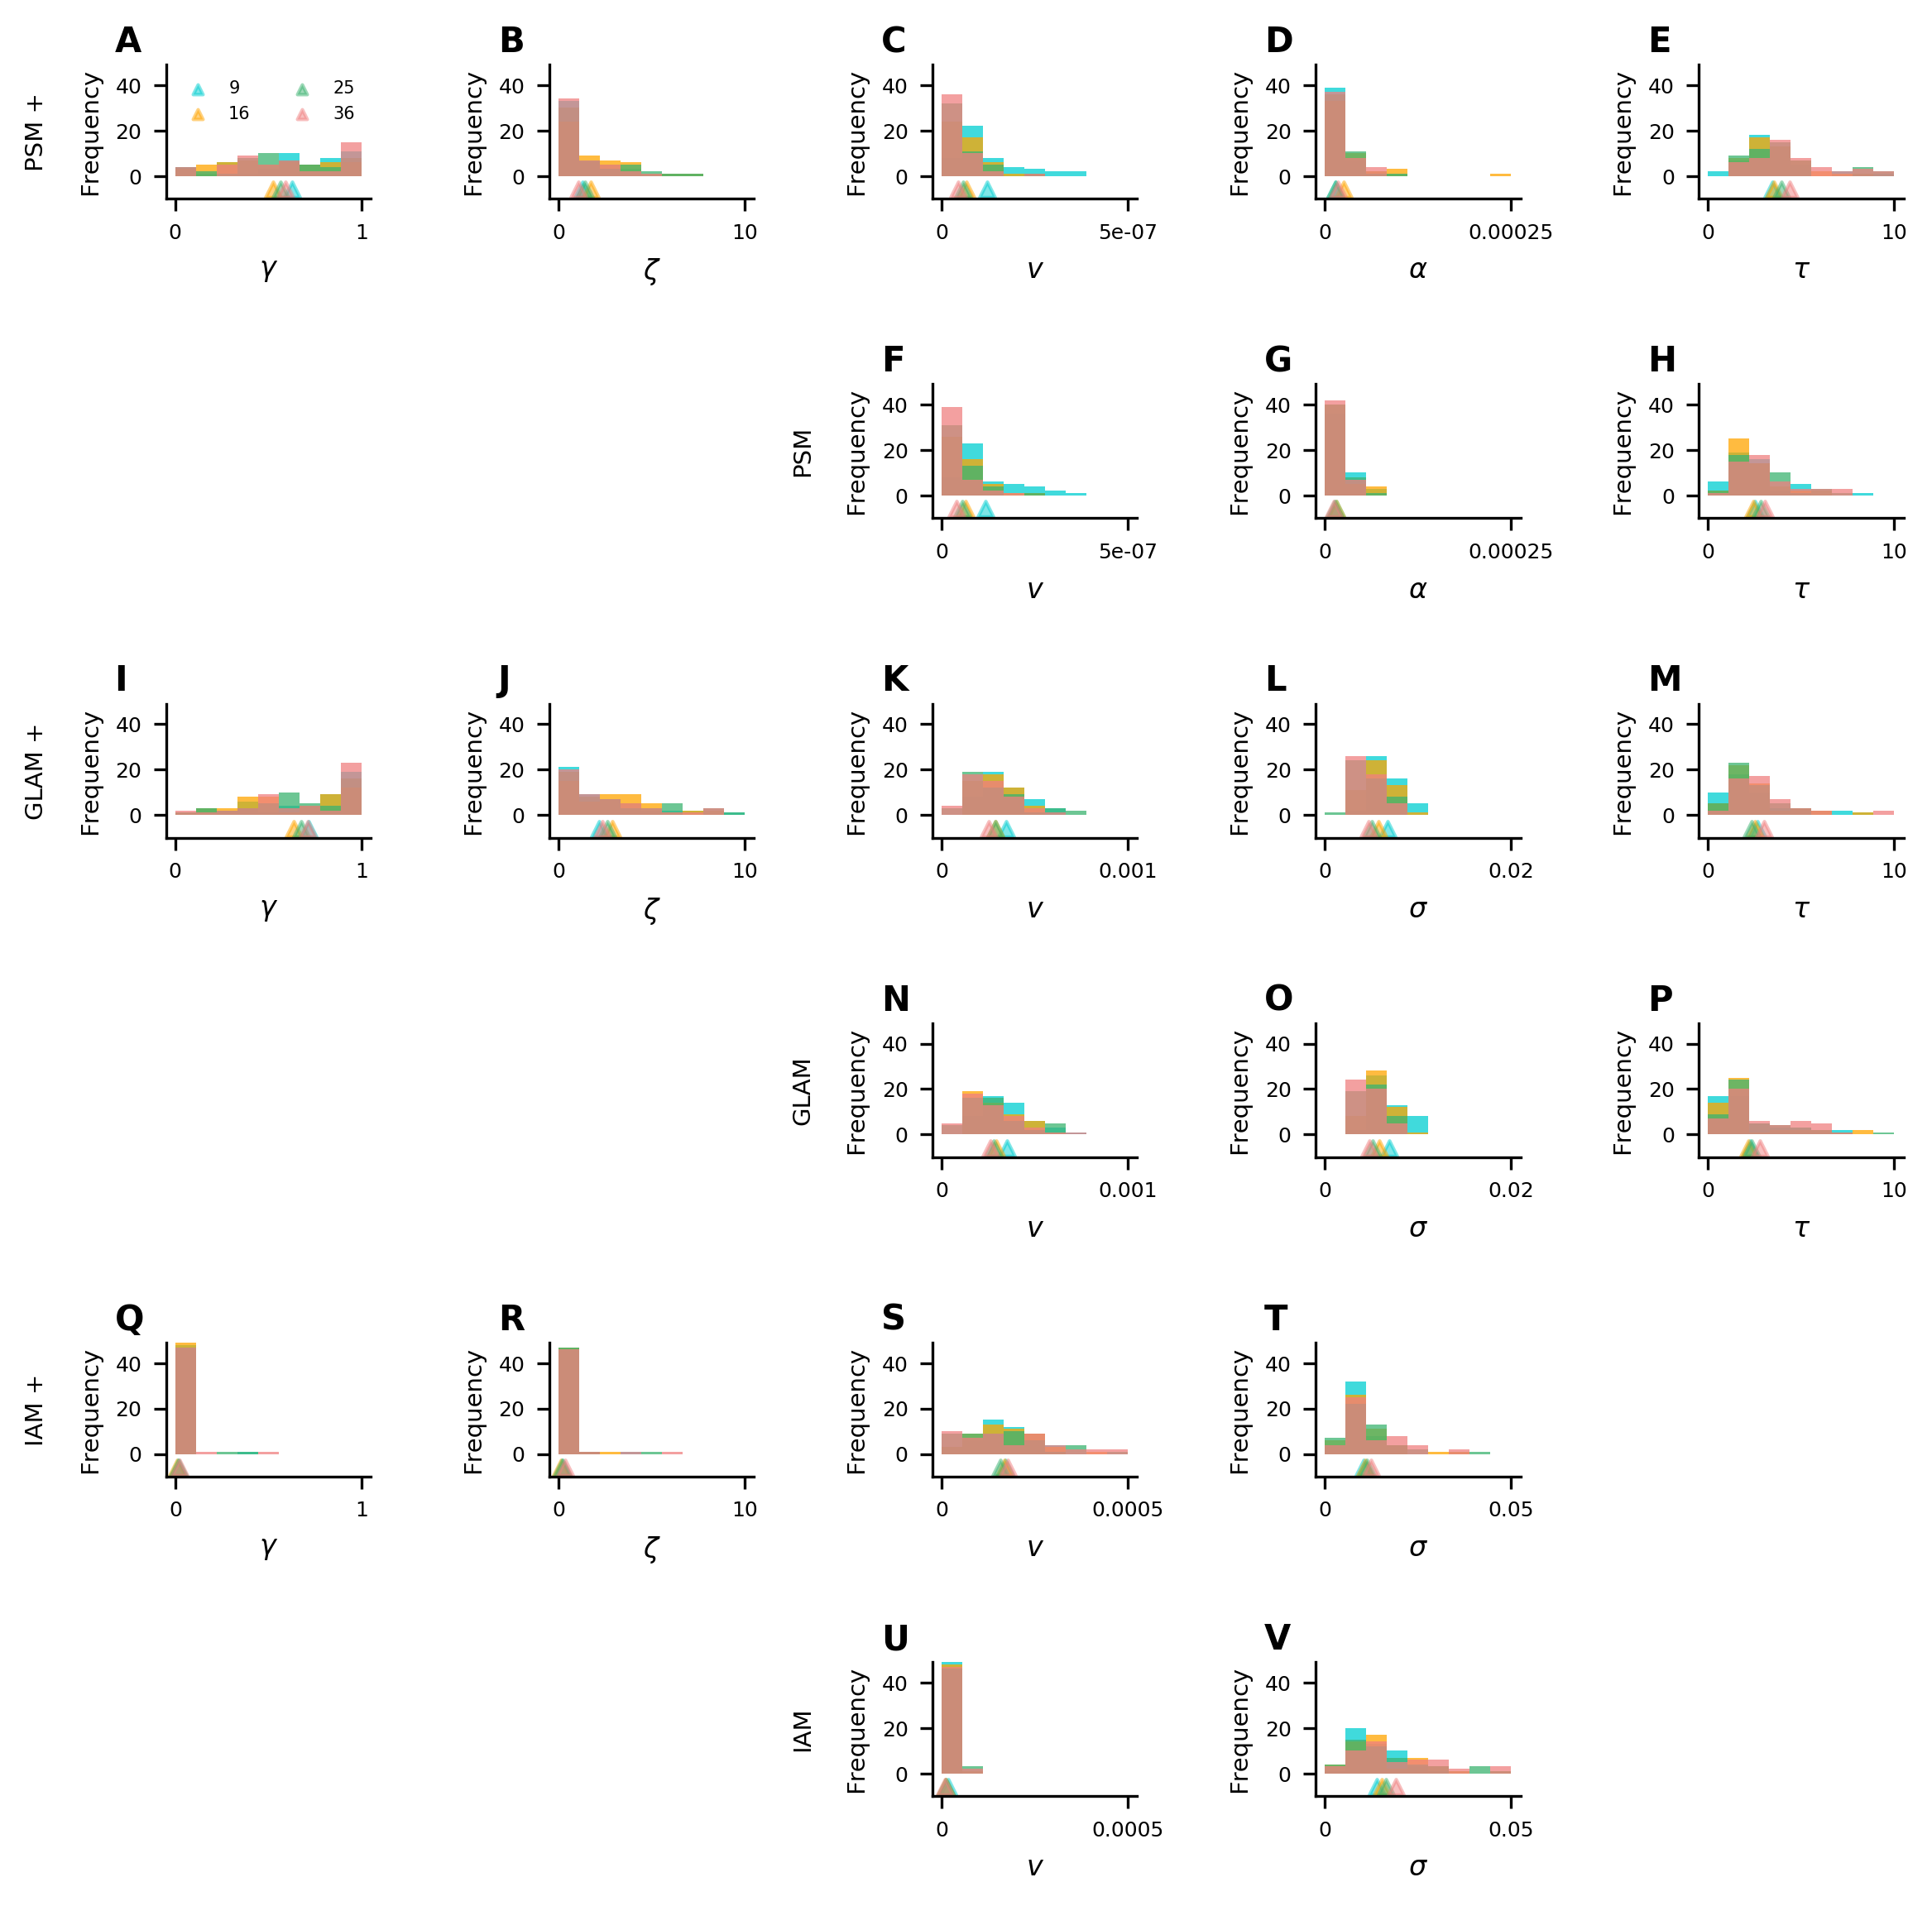

In [4]:
fig, axs = plt.subplots(6,5,figsize=cm2inch(20,20), dpi=300, sharey='row')

r = 0 # row index
for model_name, model_title in zip(model_names, model_titles):
        
    # specify model parameters
    if model_name == 'independent_accumulation':
        model_parameters = ['gamma', 'zeta', 'v', 's']
        bins = [(0, 1), (0, 10), (0, 0.0005), (0, 0.05)]
    elif model_name == 'GLAM':
        model_parameters = ['gamma', 'zeta', 'v', 's', 'tau']
        bins = [(0, 1), (0, 10), (0, 1e-3), (0, 0.02), (0, 10)]
    elif model_name == 'probabilistic_satisficing':
        model_parameters = ['gamma', 'zeta', 'v', 'alpha', 'tau']
        bins = [(0, 1), (0, 10), (0, 5e-7), (0, 2.5e-4), (0, 10)]
    else:
        raise NameError('Invalid model name')
    
    for gaze_bias in gaze_biases:
        
        print('\n\n')
        model_key = '{}_{}'.format(model_name, gaze_bias)
        if 'active' in gaze_bias:
            title = model_title+' +' 
        else:
            title = model_title
        
        for si, setsize in enumerate(setsizes):
            print('\n')
        
            for c, (par, b) in enumerate(zip(model_parameters, bins)):
                
                if gaze_bias == 'with_passive_gaze' and par in ['gamma', 'zeta']:
                    try:
                        axs[r,c].remove()
                    except KeyError:
                        continue
                else:
                    # print mean estimate
                    print('{} (set size {}): {}, mean(sd): {}({})'.format(
                        model_key, setsize, par,
                        np.mean(np.array(estimates[model_key][setsize][par])),
                        np.std(np.array(estimates[model_key][setsize][par]))))
                    
                    # plot hist
                    axs[r,c].hist(np.array(estimates[model_key][setsize][par]),
                                    bins=np.linspace(*b, 10), color=colors[si],
                                    histtype='stepfilled', alpha=0.75)
                    # also plot mean
                    if c == 0 and r == 0:
                        axs[r, c].scatter(np.mean(estimates[model_key][setsize][par]),
                                          -6, marker='^', s=20,  alpha=0.5, 
                                          color=colors[si], lw=1,
                                          label=setsize)
                    else:
                        axs[r, c].scatter(np.mean(estimates[model_key][setsize][par]),
                                          -6, marker='^', s=20,  alpha=0.5, 
                                          color=colors[si], lw=1)
                    if par in ['gamma', 'zeta', 'tau', 'alpha']:
                        axs[r,c].set_xlabel(r"$\{}$".format(par), fontsize=8)
                    elif par == 's':
                        axs[r,c].set_xlabel(r"$\sigma$", fontsize=8)
                    else:
                        axs[r,c].set_xlabel(r"${}$".format(par), fontsize=8)
                    axs[r,c].set_xticks(b)
                    axs[r,c].set_xticklabels(b)
                    if 'active' in gaze_bias:
                        if c == 0:
                            axs[r,c].set_ylabel('{}\n\nFrequency'.format(title), fontsize=7)
                        else:
                            axs[r,c].set_ylabel('Frequency', fontsize=7)
                    else:
                        if c == 2:
                            axs[r,c].set_ylabel('{}\n\nFrequency'.format(title), fontsize=7)
                        else:
                            axs[r,c].set_ylabel('Frequency', fontsize=7)
        r += 1
        
# add legend
lgnd = axs[0,0].legend(fontsize=5, ncol=2, frameon=False)
for handle in lgnd.legendHandles:
    handle.set_sizes([8])

# remove unused axes
axs[4,-1].remove()
axs[5,-1].remove()

# further plotting settings
for ax, label in zip(axs.ravel(), list('ABCDE  FGHIJKLM  NOPQRST   UV')):
    despine(ax=ax)
    ax.tick_params(axis='both', which='major', labelsize=6)
    ax.text(-0.25, 1.3, label, transform=ax.transAxes,
            fontsize=10, fontweight='bold', va='top')
    ax.set_ylim(-10, 49)

# save
fig.tight_layout()
fig.savefig('figures/Figure-S6_parameter-estimates.pdf', dpi=300)
fig.savefig('figures/Figure-S6_parameter-estimates.png', dpi=300)
fig.savefig('figures/Figure-S6_parameter-estimates.jpg', dpi=300)